#### Implementation of MobileNetV1 architecture using PyTorch

MobileNets is the efficient models for mobile and embedded vision applications. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build light weight deep neural network.

##### MobileNetV1 Architecture
1. Depthwise Separable Convolution
2. Pointwise Convolution

![MobileNet Architecture](mobilenet_v1_architecture.png)

In [1]:
import torch
import torch.nn as nn

# visualisation
from torchview import draw_graph

# !pip install transformers
# from transformers import MobileNetV1Config, MobileNetV1Model

# set device
device = torch.accelerator.current_accelerator()
print(device)

mps


In [2]:
class DepthWiseSeparable(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        """
        DepthWise Separable block of MobileNet which performs the following operations:
        (a) depthwise convolution by applying a separate filter for each channel
        (b) pointwise convolutions are applied which combine the filtered result by implementing 1 × 1 convolution

            Note:
                1. groups = in_channels used for depthwise convolution
                2. in_channels and out_channels are same for depthwise convolution
                3. bias = False due to the usage of BatchNorm
                4. To generate same height and width of output feature map as the input feature map, following should be padding for
                    * 1x1 conv : p=0
                    * 3x3 conv : p=1
                    * 5x5 conv : p=2


        Args:
          in_channels (int) : number of input channels
          out_channels (int) : number of output channels
          stride (int) : stride used for depthwise convolution

        Attributes:
            Depthwise separable convolutional block

        """
        super(DepthWiseSeparable, self).__init__()
        self.depthwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            stride=stride,
            padding=1,
            kernel_size=3,
            groups=in_channels,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(in_channels)

        self.pointwise = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            stride=1,
            padding=0,
            kernel_size=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        # Depthwise Separable Convolution
        x = self.depthwise(x)
        x = self.bn1(x)
        x = self.relu(x)

        # Pointwise Convolution
        x = self.pointwise(x)
        x = self.bn2(x)
        x = self.relu(x)

        return x

torch.Size([1, 64, 56, 56])


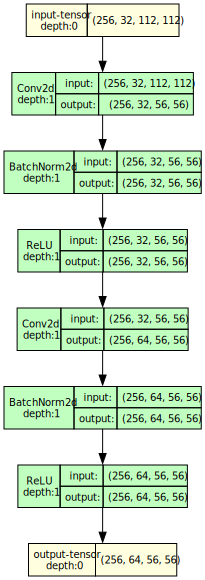

In [3]:
def build():
    x = torch.randn(1, 32, 112, 112)
    m = DepthWiseSeparable(32, 64, 2)
    print(m(x).shape)
    return m


model = build()
architecture = "DepthWiseSeparable"
model_graph = draw_graph(
    model,
    input_size=(256, 32, 112, 112),
    roll=True,
    expand_nested=True,
    graph_name="MobileNetV1",
    save_graph=True,
)

model_graph.visual_graph

In [4]:
class MobileNetV1(nn.Module):
    def __init__(self, num_classes: int = 1000):
        super(MobileNetV1, self).__init__()

        # Initial convolution layer
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
        )

        # Depthwise separable convolutions
        self.features = nn.Sequential(
            self.features,
            DepthWiseSeparable(32, 64, 1),
            DepthWiseSeparable(64, 128, 2),
            DepthWiseSeparable(128, 128, 1),
            DepthWiseSeparable(128, 256, 2),
            DepthWiseSeparable(256, 256, 1),
            DepthWiseSeparable(256, 512, 2),

            DepthWiseSeparable(512, 512, 1),
            DepthWiseSeparable(512, 512, 1),
            DepthWiseSeparable(512, 512, 1),
            DepthWiseSeparable(512, 512, 1),
            DepthWiseSeparable(512, 512, 1),

            DepthWiseSeparable(512, 1024, 2),
            DepthWiseSeparable(1024, 1024, 1)
        )

        # Average pooling and classification layer
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(nn.Linear(1024, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [ ]:
def calculate_accuracy(model, dataloader, device):
    model.eval() # set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    model.train()
    return 100 * correct / total

def load_model(is_new_training, path_to_weights=None, num_classes=1000):
    if is_new_training:
        model = MobileNetV1(num_classes=num_classes)
    else:
        if path_to_weights is None:
            raise ValueError("Path to weights must be provided for loading pre-trained model.")
        
        model = MobileNetV1(num_classes=num_classes)
        model.load_state_dict(torch.load(path_to_weights, map_location=device))
    
    model.to(device)
    return model

torch.Size([1, 1000])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              ReLU-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 64, 112, 112]           2,048
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
DepthWiseSeparable-10         [-1, 64, 112, 112]               0
           Conv2d-11           [-1, 64, 56, 56]             576
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
           Conv2

In [ ]:
from torchinfo import summary
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

dataset = "/Users/hinsun/Workspace/ComputerScience/DeepLearning/data"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

train_batch_size = 128
train_loader = DataLoader(
    datasets.CIFAR10(
        root=dataset,
        train=True,
        download=True,
        transform=transform,
    ),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=2,
)

lr = 1e-3
momentum = 0.9
epochs = 10

model = MobileNetV1(num_classes=1000).to(device)

cross = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
print(next(model.parameters()).device)

for epoch in range(epochs):
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # convert to device
        inputs, labels = inputs.to(device), labels.to(device).to(torch.float32)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = cross(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            
    print(f'Epoch [{epoch + 1}/{epochs}] completed.')

mps:0
Epoch [1/10], Step [1/391], Loss: 7.0665
Epoch [1/10], Step [101/391], Loss: 2.3326
Epoch [1/10], Step [201/391], Loss: 2.1746
Epoch [1/10], Step [301/391], Loss: 2.0655
Epoch [1/10] completed.
Epoch [2/10], Step [1/391], Loss: 1.8730
Epoch [2/10], Step [101/391], Loss: 1.7054
Epoch [2/10], Step [201/391], Loss: 1.7032
Epoch [2/10], Step [301/391], Loss: 1.6015
Epoch [2/10] completed.
Epoch [3/10], Step [1/391], Loss: 1.6886
Epoch [3/10], Step [101/391], Loss: 1.6943
Epoch [3/10], Step [201/391], Loss: 1.5645
Epoch [3/10], Step [301/391], Loss: 1.7344
Epoch [3/10] completed.
Epoch [4/10], Step [1/391], Loss: 1.5287
Epoch [4/10], Step [101/391], Loss: 1.3826
Epoch [4/10], Step [201/391], Loss: 1.4426
Epoch [4/10], Step [301/391], Loss: 1.4565
Epoch [4/10] completed.
Epoch [5/10], Step [1/391], Loss: 1.3711
Epoch [5/10], Step [101/391], Loss: 1.4403
Epoch [5/10], Step [201/391], Loss: 1.4810
Epoch [5/10], Step [301/391], Loss: 1.3236
Epoch [5/10] completed.
Epoch [6/10], Step [1/39

KeyboardInterrupt: 